<a href="https://colab.research.google.com/github/ollihansen90/linclassifiers/blob/main/Futureskills/LinClass_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitel 8 - Perzeptron

## Setup

In [ ]:
# Dieser Block entfällt im Jupyter-Hub, weil die Daten schon auf dem Server liegt
!wget -nc -q https://raw.githubusercontent.com/ollihansen90/linclassifiers/main/Futureskills/utils/utils.zip
!unzip -qq utils.zip -d utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from utils.utils import generate_data, show_vid
from utils.utils_linclass_08 import draw

C:\Users\ollih\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In diesem Notebook soll der Lernschritt eines Perzeptrons implementiert werden. Wie im Video bereits erklärt, ist ein Perzeptron ein linearer Klassifizierer mit einer Aktivierungsfunktion, die für eine beliebige (reelle) Eingabe das Vorzeichen zurückgibt.

## Daten generieren
Die Daten werden genau wie die in Aufgabe 2 von Kapitel 7 generiert. Es handelt sich also um zwei Punktewolke, die sich linear trennen lassen. Die blauen Punkte haben Label `+1`, die orangenen Punkte haben Label `-1`. Beispielhaft wird ebenso eine Gerade eingezeichnet, die das Klassifikationsproblem (noch) nicht löst.

AttributeError: 'FigureCanvasAgg' object has no attribute 'to_string_rgb'

<Figure size 700x700 with 0 Axes>

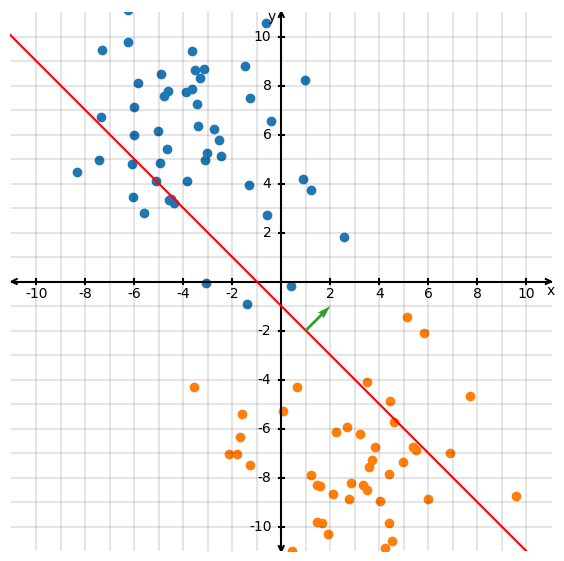

In [2]:
data, label = generate_data()
w = np.array([1,1,-1])

plt.figure(figsize=[7,7])
plt.imshow(draw(w, data, label))
plt.axis("off")
plt.show()

## Update-Schritt
Wie im Video bereits erklärt, kann die Klassifikationsgerade schrittweise mit Hilfe der Perzeptron-Lernregel angepasst werden. Hierbei werden die Gewichte, angepasst mit dem Threshold-Trick (also erweitert um `-1`) folgendermaßen aktualisiert: $w_{t+1} = w_t+\Delta w_t$ mit $\Delta w_t= \epsilon\cdot(s^\mu-y)\cdot x$. Die einzelnen Parameter in der Formel haben folgende Bedeutung:
- $\epsilon$: Lernrate, im Code `lr`
- $s^\mu$: Ausgabe des Perzeptrons (also `+1` oder `-1`), im Code `out`
- $y$: Label von Punkt $x$ (`+1` oder `-1`), im Code `label`
- $x$: Punkt, der in das Perzeptron gegeben wird, im Code `data`.

Da es sich bei `data` und `label` um lange Listen handelt, werden diese eintragsweise verarbeitet, indem ein Index durch die Liste läuft. Der `i`-te Eintrag wäre hier `data[i]`, bzw. `label[i]`.

Die Aktivierungsfunktion, die das Vorzeichen einer Eingabe zurückgibt, wurde über eine `if`-Abfrage implementiert.

Sind Label und Ausgabe des Perzeptrons gleich, so gibt es keine Veränderung der Gewichte, da $\Delta w_t= \epsilon\cdot(1-1)\cdot x=0$ bzw. $\Delta w_t= \epsilon\cdot(-1-(-1))\cdot x=0$ gilt.

In [ ]:
datal, label = generate_data()

# --- Gewichte und Lernrate anpassen ---
w = np.array(
        [4,-4,-1]
    )
lr = 0.001
# -------------------------------------

vid = [draw(w, data, label)]

for i in trange(len(data)):
    out = data[i]@w # Skalarprodukt des Datenpunktes mit dem Gewichtsvektor

    # Vorzeichenfunktion
    if out>=0:
        out = 1
    else:
        out = -1

    # Berechne Updateschritt
    dw = lr*(label[i]-out)*data[i]
    # Wende Updateschritt an
    w = w+dw

    # Überspringe alle Bilder, in denen sich nichts ändert
    if out == label[i]:
        continue
    image = draw(w, data, label)
    vid.append(image)

show_vid(vid)

## Update über Mehrere Epochen
Üblicherweise wird ein Perzeptron über mehrere Epochen trainiert, da das Klassifikationsproblem oftmals nach nur einer Epoche nicht gelöst ist. "Epoche" ist hier so definiert, dass jeder Datenpunkt einmal betrachtet wurde und entsprechend ein Updateschritt durchgeführt wurde.

Die Funktion `update_epoch` führt den Updateschritt für eine Epoche durch, ohne die Abbildungen für jeden Updateschritt zu erstellen.

In [ ]:
def update_epoch(w, lr, data, label):
    # Durchlaufe den Index jedes Datenpunktes
    for i in range(len(data)):
        out = data[i]@w # Skalarprodukt des Datenpunktes mit dem Gewichtsvektor

        # Vorzeichenfunktion
        if out>=0:
            out = 1
        else:
            out = -1

        # Berechne Updateschritt
        dw = lr*(label[i]-out)*data[i]
        # Wende Updateschritt an
        w = w+dw
    return w

## Perzeptron-Training
Im letzten Abschnitt soll nun alles zusammengesetzt werden: Ein Perzeptron wird definiert, das das gegebene Klassifikationsproblem nicht löst. Schrittweise werden die Gewichte jetzt so angepasst, dass ein Klassifikator entsteht, der die beiden Klassen korrekt voneinander trennt.

Im unteren Abschnitt können Hyperparameter festgelegt werden. Diese Hyperparameter sind die *Lernrate* `lr`, eine *Toleranz* `tol`, sowie eine *maximale Anzahl an Schritten* `n_max`.

Die Toleranz und die Maximalzahl an Schritten definieren eine Abbruchbedingung des Trainings. Nur in den seltensten Fällen gibt es Problemstellungen, die linear trennbar sind. Wie oben beobachtet werden konnte, gibt es Updateschritte, solange es noch falsche Klassifikationen gibt. Sind die Klassen nicht linear trennbar, so würde das Training ewig weitergeführt werden.

Die einfachste Abbruchbedingung ist eine maximale Anzahl an Schritten. Sobald diese Zahl erreicht wird, soll das Training beendet werden. Hierbei ist es unerheblich, wie gut das Problem zu dem Zeitpunkt gelöst ist.

Eine weitere Abbruchbedingung ist die Toleranz. Die Toleranz kann sehr unterschiedlich definiert sein. Im folgenden Codeblock ist sie so definiert, dass das Training abgebrochen wird, sobald sich die Gewichte von einer Epoche zur nächsten nicht mehr stark ändern.

In [ ]:
def run(lr,n_max=50, tol=1e-5):
    # Generiere Daten
    data, label = generate_data()

    # Initialisiere Gewichte w
    w = np.array([1,-1,1])

    # Initialisiere Video mit dem Startbild
    vid = [draw(w, data, label)]

    # Training
    for epoch in trange(n_max):
        w_alt = w.copy()

        # Update der Gewichte
        w = update_epoch(w, lr, data, label)

        # Einzeichnen der Punkte und des Perzeptrons
        image = draw(w, data, label)
        vid.append(image)

        # Abbruch bei wenig Veränderung
        if np.linalg.norm(w-w_alt)<tol:
            break
    show_vid(vid)

# --- Hier können die Hyperparameter erstellt werden ---
lernrate = 0.0001
tol = 0.00001
n_max = 50
# ---------------------------------------------------------

run(lr=lernrate, n_max=n_max, tol=tol)